# Introduction

This notebook shows the difference between identifying $\mathbf{m}^*(\varphi)$ and $\mathbf{K}(\varphi)$ as opposed to identifying $\mathbf{m}^*(\varphi)$ alone from this control structure:

$$\mathbf{m}(t) = \mathbf{m}^*(\varphi) - \mathbf{K}(\varphi)\mathbf{s}(t)$$

# Imports

In [1]:
import sys
sys.path.append('../src')

In [2]:
import numpy as np
import pandas
from gaitanalysis.controlid import SimpleControlSolver

In [3]:
import utils
from gait_landmark_settings import settings

In [4]:
%matplotlib inline

In [5]:
from IPython.core.pylabtools import figsize
figsize(10, 8)

# Load and Process Data for 1 Trial

In [6]:
trials_dir = utils.config_paths()['raw_data_dir']

In [7]:
trial_number = '068'

In [8]:
trial = utils.Trial('068')

In [9]:
trial.prep_data('Longitudinal Perturbation')

Loading pre-cleaned data: /home/moorepants/Manuscripts/gait-control-direct-id-paper/processed-data/cleaned-data/068-longitudinal-perturbation.h5
_write_event_data_frame_to_disk took 1.70 s to execute.
Loading pre-computed inverse dynamics from /home/moorepants/Manuscripts/gait-control-direct-id-paper/processed-data/gait-data/068-longitudinal-perturbation.h5.
_write_inverse_dynamics_to_disk took 0.58 s to execute.
Loading pre-computed gait cycles from /home/moorepants/Manuscripts/gait-control-direct-id-paper/processed-data/gait-data/068-longitudinal-perturbation.h5.
_section_into_gait_cycles took 0.08 s to execute.


In [10]:
gait_data = trial.gait_data_objs['Longitudinal Perturbation']
gait_cycles = gait_data.gait_cycles

In [11]:
num_cycles = gait_cycles.shape[0]
solver = SimpleControlSolver(gait_cycles.iloc[:num_cycles * 3 / 4],
                             trial.sensors,
                             trial.controls,
                             validation_data=gait_cycles.iloc[num_cycles * 3 / 4:])

# Identification only $\mathbf{m}^*(t)$

In [12]:
gain_inclusion_matrix = np.zeros((len(trial.controls), len(trial.sensors))).astype(bool)

In [13]:
result = solver.solve(gain_inclusion_matrix=gain_inclusion_matrix)

In [14]:
no_control_vafs = utils.variance_accounted_for(result[-1], solver.validation_data, trial.controls)

Generating validation plot.
0.58 s


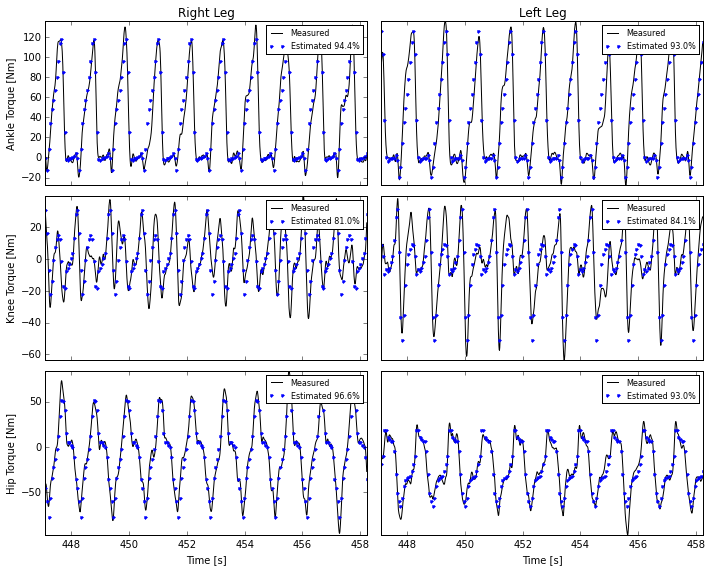

In [15]:
fig, axes = utils.plot_validation(result[-1], gait_data.data, no_control_vafs)

# Identify $\mathbf{m}^*(t)$ and $\mathbf{K}(\varphi)$ (joint isolated structure)

In [16]:
for i, row in enumerate(gain_inclusion_matrix):
    row[2 * i:2 * i + 2] = True

In [17]:
result = solver.solve(gain_inclusion_matrix=gain_inclusion_matrix)

In [18]:
joint_isolated_control_vafs = utils.variance_accounted_for(result[-1],
                                                           solver.validation_data,
                                                           trial.controls)

Generating validation plot.
0.55 s


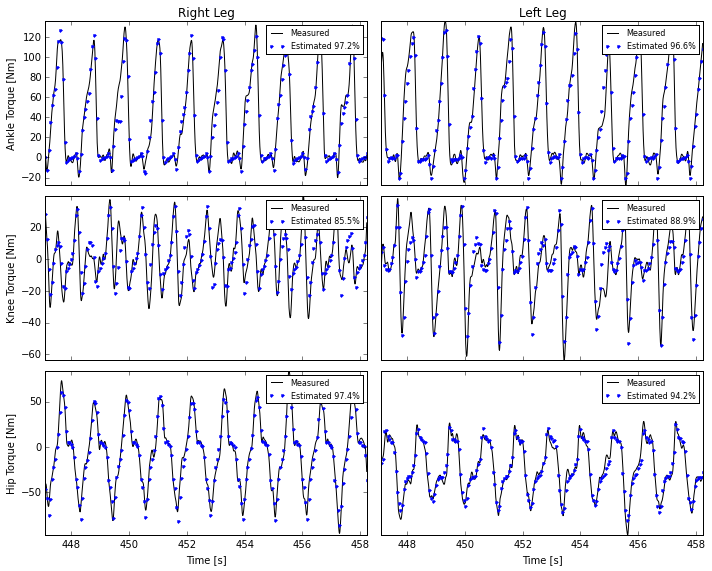

In [19]:
fig, axes = utils.plot_validation(result[-1], gait_data.data, joint_isolated_control_vafs)

# Identify $\mathbf{m}^*(t)$ and $\mathbf{K}(\varphi)$ (full gain matrix)

Note that this solution will take 30 minutes to and hour if the `ignore_cov` flag is False. This is due to a speed bottleneck in `dtk.process.least_squares_variance`.

In [20]:
result = solver.solve(ignore_cov=True)

In [21]:
full_control_vafs = utils.variance_accounted_for(result[-1],
                                                 solver.validation_data,
                                                 trial.controls)

Generating validation plot.
0.56 s


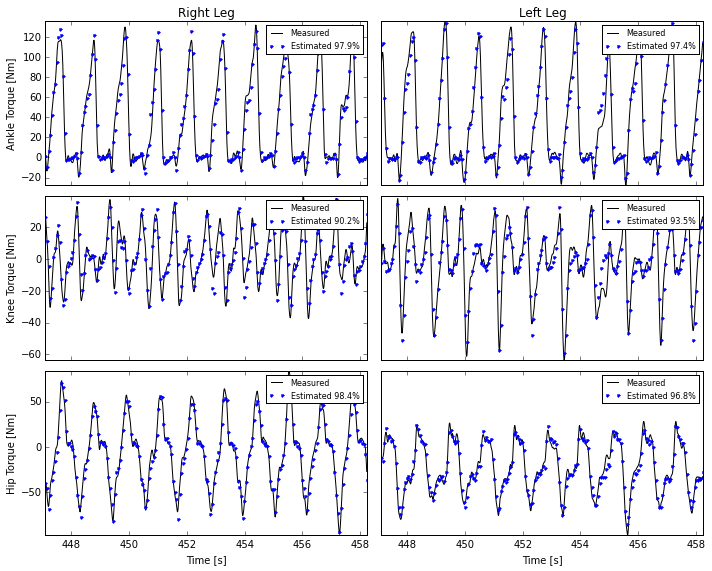

In [22]:
fig, axes = utils.plot_validation(result[-1], gait_data.data, full_control_vafs)

# Compare VAF for each identification

In [23]:
vafs = no_control_vafs.copy()
for k, v in vafs.items():
    vafs[k] = [v, joint_isolated_control_vafs[k], full_control_vafs[k]]

In [24]:
vaf_df = pandas.DataFrame(vafs, index=['No Control', 'Joint Isolated Control', 'Full Control'])
vaf_df.T

,No Control,Joint Isolated Control,Full Control
Left.Ankle.PlantarFlexion.Moment,0.930155,0.965969,0.974489
Left.Hip.Flexion.Moment,0.930070,0.942240,0.968361
Left.Knee.Flexion.Moment,0.841471,0.888560,0.935461
Right.Ankle.PlantarFlexion.Moment,0.943745,0.971717,0.979205
Right.Hip.Flexion.Moment,0.965763,0.973759,0.984328
Right.Knee.Flexion.Moment,0.810439,0.854908,0.901859


In [25]:
mean_vaf = vaf_df.mean(axis=1)
mean_vaf

No Control                0.903607
Joint Isolated Control    0.932859
Full Control              0.957284
dtype: float64

The joint isolated gain matrix structure helps the base model account for ~3% more of the data. 

In [26]:
100.0 * (mean_vaf.iloc[1] - mean_vaf.iloc[0])

2.9251732143615761

So the full gain matrix helps the base model account for ~6% more of the data.

In [27]:
100.0 * (mean_vaf.iloc[2] - mean_vaf.iloc[0])

5.3676526890910186

# Footer

In [28]:
!git rev-parse HEAD

6af0c229bb0a9edf78f8489d5f0efe02d5685a57


In [29]:
!git --git-dir=/home/moorepants/src/GaitAnalysisToolKit/.git --work-tree=/home/moorepants/src/GaitAnalysisToolKit rev-parse HEAD

9e80dfdcfe0a14b44e0ebcbadb6e9e827d215c3c


In [30]:
%install_ext http://raw.github.com/jrjohansson/version_information/master/version_information.py

Installed version_information.py. To use it, type:
  %load_ext version_information


In [31]:
%load_ext version_information

In [32]:
%version_information numpy, scipy, pandas, matplotlib, tables, oct2py, dtk, gaitanalysis

Software,Version
Python,2.7.9 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython,3.0.0
OS,Linux 3.13.0 49 generic x86_64 with debian jessie sid
numpy,1.9.2
scipy,0.15.1
pandas,0.16.0
matplotlib,1.4.2
tables,3.1.1
oct2py,3.1.0
dtk,0.4.0


In [33]:
!conda list

# packages in environment at /home/moorepants/anaconda/envs/gait-direct-id-paper:
#
backports.ssl-match-hostname 3.4.0.2                   <pip>
cairo                     1.12.18                       0  
dateutil                  2.4.1                    py27_0  
dynamicisttoolkit         0.4.0                    py27_0  
fastcache                 1.0.2                    py27_0  
fontconfig                2.11.1                        2  
freetype                  2.4.10                        0  
gaitanalysistoolkit (/home/moorepants/src/GaitAnalysisToolKit) 0.2.0.dev0                <pip>
hdf5                      1.8.14                        0  
ipython                   3.0.0                    py27_0  
ipython-notebook          3.0.0                    py27_1  
jinja2                    2.7.3                    py27_1  
jsonschema                2.4.0                    py27_0  
libpng                    1.5.13                        1  
libsodium                 0.4.5         

In [34]:
!pip freeze

backports.ssl-match-hostname==3.4.0.2
DynamicistToolKit==0.4.0
fastcache==1.0.2
-e git+git@github.com:csu-hmc/GaitAnalysisToolKit.git@9e80dfdcfe0a14b44e0ebcbadb6e9e827d215c3c#egg=GaitAnalysisToolKit-origin_speedup-inverse-dynamics
ipython==3.0.0
Jinja2==2.7.3
jsonschema==2.4.0
MarkupSafe==0.23
matplotlib==1.4.2
mistune==0.5.1
nose==1.3.4
numexpr==2.3.1
numpy==1.9.2
oct2py==3.1.0
pandas==0.16.0
ptyprocess==0.4
Pygments==2.0.2
pyparsing==2.0.1
PySide==1.2.1
python-dateutil==2.4.2
pytz==2015.2
PyYAML==3.11
pyzmq==14.5.0
scipy==0.15.1
seaborn==0.5.1
six==1.9.0
snakeviz==0.3.1
sympy==0.7.6
tables==3.1.1
terminado==0.5
tornado==4.1
